# Cats vs. Dogs: Transfer Learning with little data

Compare the performance of VGG16 and other pretrained Convolutional Nets (InceptionV3 and ResNet50).

### Show Example Images

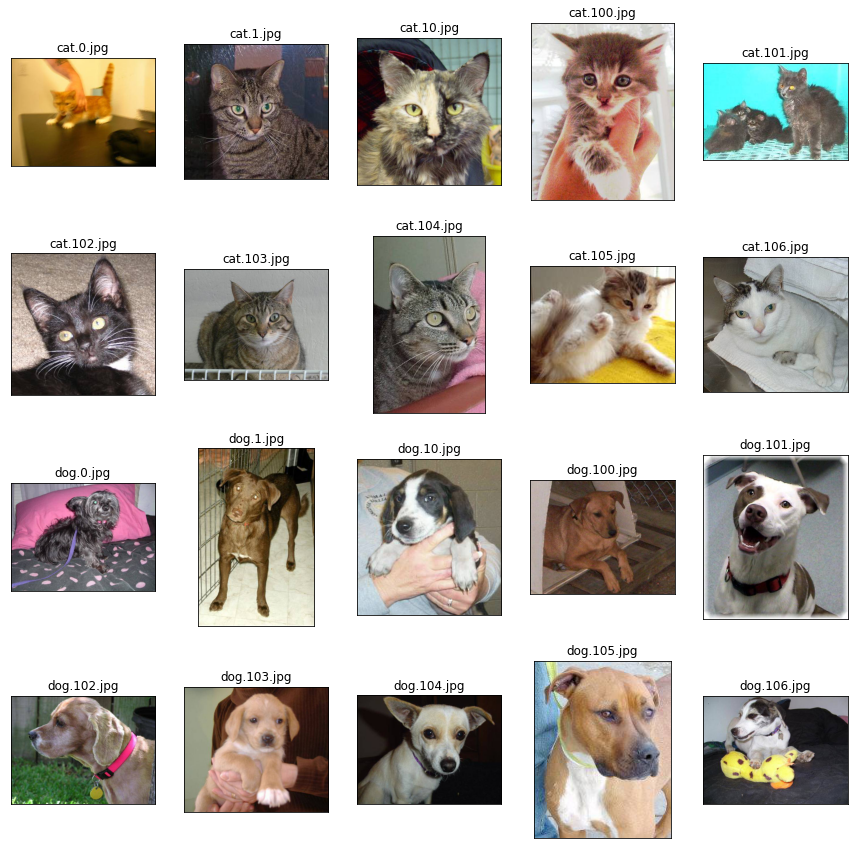

In [1]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
%matplotlib inline

files = [[path+f for f in os.listdir(path)[:10]] for path in [f'F:/Study/UMT/S7/Deep Learning/Assignments/Assignment 3 Mid/dogs-vs-cat-small/train/{x}/' for x in ['cats', 'dogs']]]

fig, axs = plt.subplots(4, 5, figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []})

for ax, img in zip(axs.flatten(), [item for sublist in files for item in sublist]):
    ax.imshow(load_img(img))
    ax.set_title(img.split('/')[-1])

## Training a Small ConvNet from Scratch

A classic setup of three convolution layers with a ReLU activation, followed by max-pooling layers. On top two fully-connected layers and a single node with sigmoid activation for binary classification (cat or dog).

In [2]:
import numpy as np
import pandas as pd
import keras, tensorflow
import time

print('Keras', keras.__version__)
print('TensorFlow', tensorflow.__version__)

Keras 2.4.3
TensorFlow 2.3.1


In [3]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

input_tensor = Input(shape=(150,150,3))

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [4]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Provide Training and Test as Validation Image Using ImageDataGenerator

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir      = 'F:/Study/UMT/S7/Deep Learning/Assignments/Assignment 3 Mid/dogs-vs-cat-small/train'
validation_dir = 'F:/Study/UMT/S7/Deep Learning/Assignments/Assignment 3 Mid/dogs-vs-cat-small/validation'
test_dir = 'F:/Study/UMT/S7/Deep Learning/Assignments/Assignment 3 Mid/dogs-vs-cat-small/test'

train_samples      = 2000
validation_samples = 1000

target_size    = (150,150)  # all images will be resized to 150x150
batch_size     = 20

# rescale and augment training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# rescale validation data
test_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
epochs = 30

start_time = time.time()
history_simple = model.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
100/100 - 123s - loss: 0.8054 - accuracy: 0.5500 - val_loss: 0.6733 - val_accuracy: 0.5900
Epoch 2/30
100/100 - 71s - loss: 0.6968 - accuracy: 0.6215 - val_loss: 0.8273 - val_accuracy: 0.5480
Epoch 3/30
100/100 - 71s - loss: 0.6370 - accuracy: 0.6605 - val_loss: 0.7950 - val_accuracy: 0.5180
Epoch 4/30
100/100 - 71s - loss: 0.5894 - accuracy: 0.6855 - val_loss: 0.6131 - val_accuracy: 0.6410
Epoch 5/30
100/100 - 71s - loss: 0.5554 - accuracy: 0.7125 - val_loss: 0.5826 - val_accuracy: 0.6700
Epoch 6/30
100/100 - 70s - loss: 0.5439 - accuracy: 0.7180 - val_loss: 0.5402 - val_accuracy: 0.7290
Epoch 7/30
100/100 - 71s - loss: 0.5245 - accuracy: 0.7350 - val_loss: 0.5664 - val_accuracy: 0.7000
Epoch 8/30
100/100 - 56s - loss: 0.5145 - accuracy: 0.7565 - val_loss: 0.4994 - val_accuracy: 0.7560
Epoch 9/30
100/100 - 46s - loss: 0.4813 - accuracy: 0.7645 - val_loss: 0.6275 - val_accuracy: 0.7120
Epoch 10/30
100/100 - 49s - loss: 0.4718 - accuracy: 0.7725 - val_loss: 0.5867 - val_accur

### Investigating Model Accuracy

The results can vary due to the random initialization. But the (validation) accuracy should be more or less close to 80% (like in the original blog post). Looking at the graphs we ses that the training accuracy continuously improves while the validation accuracy does not change much after ~15 epochs - a clear sign for overfitting.

In [7]:
def plot_history(history, acc_line=None, title=None, acc_lim=[0.5,1.0]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    if title:
        fig.suptitle(title, fontsize=16)
    
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    if acc_line:
        ax1.axhline(y=acc_line, linewidth=2, linestyle='dashed', color='lightgrey')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    #ax1.set_yticks(np.arange(0., 1.1, .1))
    ax1.set_ylim(acc_lim)
    ax1.legend(['Train', 'Test'])
    ax1.grid(b=True, which='major', color='lightgrey', linestyle='dotted')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim([0, 1.2])
    ax2.legend(['Train', 'Test'])
    ax2.grid(b=True, which='major', color='lightgrey', linestyle='dotted')

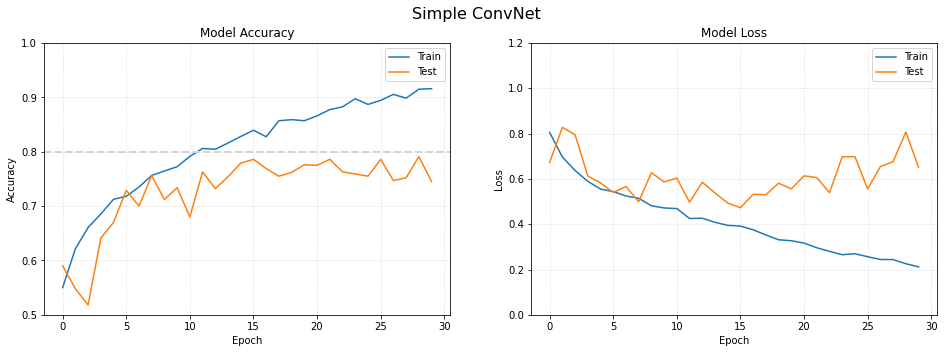

In [8]:
plot_history(history_simple, acc_line=0.8, title='Simple ConvNet')

In [9]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
    shuffle = False,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


In [10]:
test_loss, test_acc = model.evaluate (test_generator, steps = 50)

50/50 [==============================] - 16s 311ms/step - loss: 0.7500 - accuracy: 0.7260


In [11]:
print (test_acc)

0.7260000109672546


## Using bottleneck features of a pre-trained VGG16 network

We will be using VGG16 with pre-trained weights based on ImageNet divided into two steps:

  * compute bottleneck features for all 2000 training images and 1000 validation images of cats and dogs
  * create new binary classifier and train it with bottleneck features.

**Note: there is no data augmentation applied - so expect to see more overfitting.**

### Create VGG16 model with pre-trained weights

**Important**: Exclude the top layers (the dense classfication layers) because we are only interested in the output of the convolutional layers.

In [12]:
from keras.applications.vgg16 import VGG16

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

### Extract Bottleneck Features


In [13]:
def get_bottleneck_features(model, image_dir, target_size, samples, batch_size=20):
    datagen   = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_directory(image_dir,
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    return model.predict(generator, samples // batch_size)

train_data_vgg16 = get_bottleneck_features(base_model_vgg16, train_dir, target_size, train_samples, batch_size)
print('created bottleneck features for training:', train_data_vgg16.shape)

validation_data_vgg16 = get_bottleneck_features(base_model_vgg16, validation_dir, target_size, validation_samples, batch_size)
print('created bottleneck features for validation:', validation_data_vgg16.shape)

train_labels = np.array([0] * (train_samples // 2) + [1] * (train_samples // 2))
validation_labels = np.array([0] * (validation_samples // 2) + [1] * (validation_samples // 2))

Found 2000 images belonging to 2 classes.
created bottleneck features for training: (2000, 4, 4, 512)
Found 1000 images belonging to 2 classes.
created bottleneck features for validation: (1000, 4, 4, 512)


### Train a Classifier with Bottleneck Features

Classifier Setup: A dense layer with 256 neurons plus Dropout of 0.5 with a final layer of one neuron.

In [14]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout

def get_top_model(input_shape):
    input = Input(input_shape)
    x = Flatten()(input)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    prediction = Dense(1, activation='sigmoid')(x)
    return Model(inputs=input, outputs=prediction)

top_model_vgg16 = get_top_model(train_data_vgg16.shape[1:])

top_model_vgg16.compile(loss='binary_crossentropy',
                        optimizer='rmsprop',
                        metrics=['accuracy'])

In [15]:
epochs = 30

start_time = time.time()
history_vgg16_top = top_model_vgg16.fit(train_data_vgg16, train_labels,
                                        verbose=2,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(validation_data_vgg16, validation_labels))
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
100/100 - 2s - loss: 0.7554 - accuracy: 0.7445 - val_loss: 0.3794 - val_accuracy: 0.8190
Epoch 2/30
100/100 - 2s - loss: 0.3599 - accuracy: 0.8550 - val_loss: 0.3424 - val_accuracy: 0.8450
Epoch 3/30
100/100 - 2s - loss: 0.2716 - accuracy: 0.8850 - val_loss: 0.2695 - val_accuracy: 0.9050
Epoch 4/30
100/100 - 2s - loss: 0.2718 - accuracy: 0.8935 - val_loss: 0.2812 - val_accuracy: 0.9000
Epoch 5/30
100/100 - 2s - loss: 0.2498 - accuracy: 0.9100 - val_loss: 0.2798 - val_accuracy: 0.9000
Epoch 6/30
100/100 - 2s - loss: 0.1886 - accuracy: 0.9310 - val_loss: 0.2844 - val_accuracy: 0.9050
Epoch 7/30
100/100 - 2s - loss: 0.1644 - accuracy: 0.9345 - val_loss: 0.3939 - val_accuracy: 0.8780
Epoch 8/30
100/100 - 2s - loss: 0.1418 - accuracy: 0.9495 - val_loss: 0.3357 - val_accuracy: 0.9000
Epoch 9/30
100/100 - 2s - loss: 0.1527 - accuracy: 0.9450 - val_loss: 0.4056 - val_accuracy: 0.8820
Epoch 10/30
100/100 - 2s - loss: 0.1263 - accuracy: 0.9575 - val_loss: 0.5418 - val_accuracy: 0.8640

In [16]:
model_weigths_file = 'bottleneck_fc_model_vgg16.h5'
top_model_vgg16.save_weights(model_weigths_file)

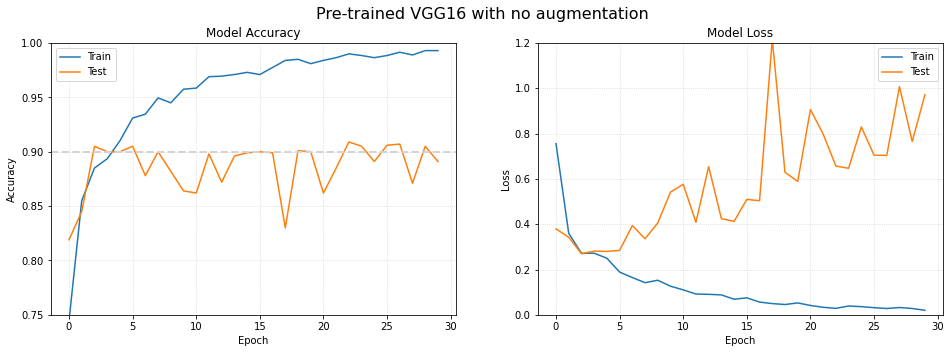

In [17]:
plot_history(history_vgg16_top, acc_line=0.9, title='Pre-trained VGG16 with no augmentation', acc_lim=[0.75,1.0])

In [18]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Dropout

In [19]:
# load pre-trained VGG16 network (without classfication layers)
base_model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
print('Model loaded.')

# set all but the last conv block to non-trainable (weights will not be updated)
for layer in base_model_vgg16.layers[:15]:
    layer.trainable = False

# create a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model_vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(model_weigths_file)

# add the model on top of the convolutional base
model = Model(inputs = base_model_vgg16.input, outputs = top_model(base_model_vgg16.output))

Model loaded.


In [20]:
from keras import optimizers

# compile model with a very slow learning rate
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['accuracy'])

In [21]:
epochs = 30

start_time = time.time()
history_tuned = model.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
100/100 - 354s - loss: 0.4414 - accuracy: 0.9090 - val_loss: 0.5183 - val_accuracy: 0.8700
Epoch 2/30
100/100 - 367s - loss: 0.2291 - accuracy: 0.9185 - val_loss: 0.4184 - val_accuracy: 0.9010
Epoch 3/30
100/100 - 369s - loss: 0.1770 - accuracy: 0.9455 - val_loss: 0.3366 - val_accuracy: 0.9050
Epoch 4/30
100/100 - 363s - loss: 0.1452 - accuracy: 0.9475 - val_loss: 0.3605 - val_accuracy: 0.9130
Epoch 5/30
100/100 - 376s - loss: 0.1155 - accuracy: 0.9595 - val_loss: 0.3870 - val_accuracy: 0.9140
Epoch 6/30
100/100 - 372s - loss: 0.1031 - accuracy: 0.9620 - val_loss: 0.3761 - val_accuracy: 0.9130
Epoch 7/30
100/100 - 358s - loss: 0.1152 - accuracy: 0.9615 - val_loss: 0.4522 - val_accuracy: 0.8850
Epoch 8/30
100/100 - 361s - loss: 0.0652 - accuracy: 0.9770 - val_loss: 0.4335 - val_accuracy: 0.9190
Epoch 9/30
100/100 - 355s - loss: 0.0594 - accuracy: 0.9825 - val_loss: 0.4265 - val_accuracy: 0.9120
Epoch 10/30
100/100 - 355s - loss: 0.0725 - accuracy: 0.9735 - val_loss: 0.3956 - 

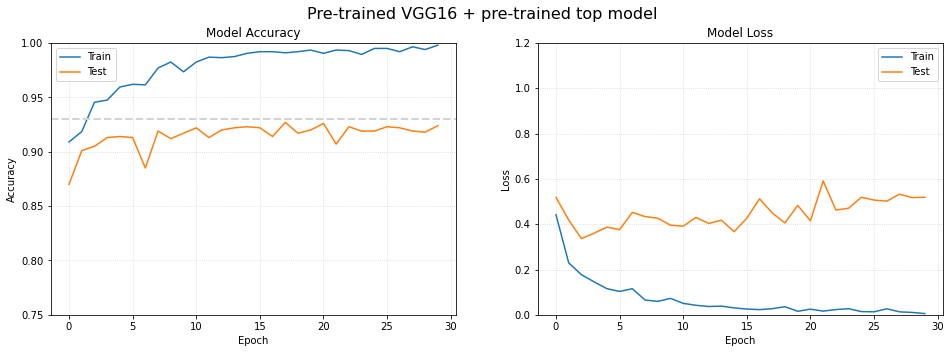

In [22]:
plot_history(history_tuned, acc_line=0.93, title='Pre-trained VGG16 + pre-trained top model', acc_lim=[0.75,1.0])

In [23]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
    shuffle = False,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


In [24]:
test_loss, test_acc = model.evaluate (test_generator, steps = 50)

50/50 [==============================] - 106s 2s/step - loss: 0.5127 - accuracy: 0.9110


In [25]:
print (test_acc)

0.9110000133514404


### Create VGG16 model with pre-trained weights

In [26]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout

# build the VGG16 network
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_vgg16base = Model(inputs=base_model.input, outputs=predictions)

print(model_vgg16base.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

In [27]:
model_vgg16base.compile(loss='binary_crossentropy',
                        optimizer='rmsprop',
                        metrics=['accuracy'])

In [28]:
epochs = 30

start_time = time.time()
history_vgg16base = model_vgg16base.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
100/100 [==============================] - 322s 3s/step - loss: 0.7753 - accuracy: 0.7340 - val_loss: 0.4065 - val_accuracy: 0.8120
Epoch 2/30
100/100 [==============================] - 323s 3s/step - loss: 0.4251 - accuracy: 0.8250 - val_loss: 0.2523 - val_accuracy: 0.8990
Epoch 3/30
100/100 [==============================] - 329s 3s/step - loss: 0.3725 - accuracy: 0.8470 - val_loss: 0.2944 - val_accuracy: 0.8640
Epoch 4/30
100/100 [==============================] - 331s 3s/step - loss: 0.3637 - accuracy: 0.8460 - val_loss: 0.2529 - val_accuracy: 0.8920
Epoch 5/30
100/100 [==============================] - 331s 3s/step - loss: 0.3103 - accuracy: 0.8660 - val_loss: 0.2583 - val_accuracy: 0.8970
Epoch 6/30
100/100 [==============================] - 323s 3s/step - loss: 0.2788 - accuracy: 0.8810 - val_loss: 0.2784 - val_accuracy: 0.8960
Epoch 7/30
100/100 [==============================] - 324s 3s/step - loss: 0.3012 - accuracy: 0.8845 - val_loss: 0.2828 - val_accuracy: 0.8960

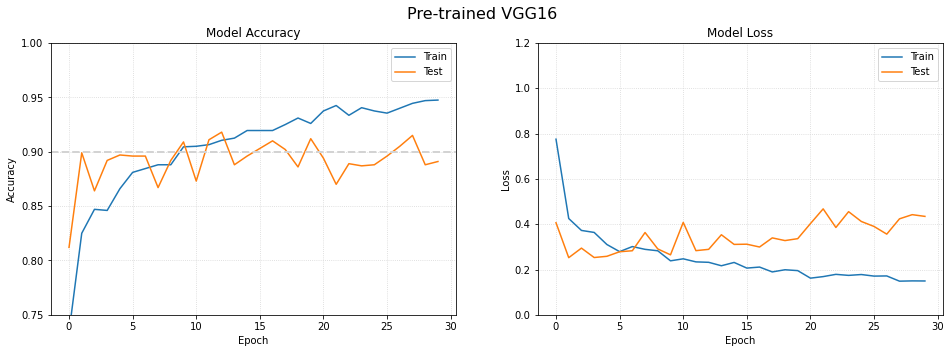

In [29]:
plot_history(history_vgg16base, acc_line=0.9, title='Pre-trained VGG16', acc_lim=[0.75, 1.0])

In [30]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
    shuffle = False,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


In [31]:
test_loss, test_acc = model_vgg16base.evaluate (test_generator, steps = 50)

50/50 [==============================] - 105s 2s/step - loss: 0.4433 - accuracy: 0.8920


In [32]:
print (test_acc)

0.8920000195503235


### Use Pre-trained InceptionV3 Model

In [33]:
from keras.applications.inception_v3 import InceptionV3

# load pre-trained weights and add global average pooling layer
base_model_incv3 = InceptionV3(weights='imagenet', input_shape=(150,150,3), include_top=False, pooling='avg')

# freeze convolutional layers
for layer in base_model_incv3.layers:
    layer.trainable = False

# define classification layers
x = Dense(256, activation='relu')(base_model_incv3.output)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_incv3 = Model(inputs=base_model_incv3.input, outputs=predictions)
#print(model_incv3.summary())

### Prepare Model Training Setup

In [34]:
model_incv3.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=0.0001),
                    metrics=['accuracy'])

### Provide Training and Validation Images using ImageDataGenerator

**Caution**: InceptionV3 requires a different image preprocessing than VGG.

In [35]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

def prep(image):
    # copy image to prevent overwriting
    return preprocess_input(image.copy())

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=prep)

test_datagen = ImageDataGenerator(preprocessing_function=prep)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [36]:
epochs = 30

start_time = time.time()
history_incv3 = model_incv3.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
100/100 [==============================] - 77s 767ms/step - loss: 0.3869 - accuracy: 0.8530 - val_loss: 0.1015 - val_accuracy: 0.9660
Epoch 2/30
100/100 [==============================] - 75s 753ms/step - loss: 0.1895 - accuracy: 0.9290 - val_loss: 0.0891 - val_accuracy: 0.9700
Epoch 3/30
100/100 [==============================] - 77s 767ms/step - loss: 0.1325 - accuracy: 0.9530 - val_loss: 0.0891 - val_accuracy: 0.9710
Epoch 4/30
100/100 [==============================] - 76s 761ms/step - loss: 0.1121 - accuracy: 0.9595 - val_loss: 0.0925 - val_accuracy: 0.9660
Epoch 5/30
100/100 [==============================] - 75s 747ms/step - loss: 0.1115 - accuracy: 0.9595 - val_loss: 0.0924 - val_accuracy: 0.9670
Epoch 6/30
100/100 [==============================] - 75s 748ms/step - loss: 0.1108 - accuracy: 0.9565 - val_loss: 0.1004 - val_accuracy: 0.9640
Epoch 7/30
100/100 [==============================] - 76s 759ms/step - loss: 0.1050 - accuracy: 0.9610 - val_loss: 0.0874 - val_ac

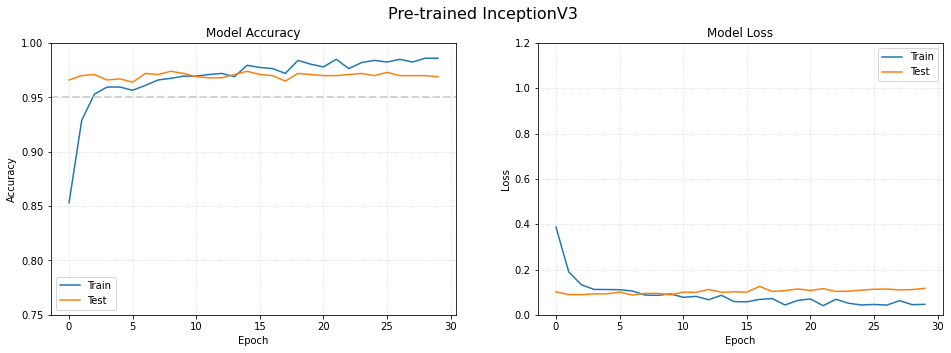

In [37]:
plot_history(history_incv3, acc_line=0.95, title="Pre-trained InceptionV3", acc_lim=[0.75,1.0])

In [38]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
    shuffle = False,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


In [39]:
test_loss, test_acc = model_incv3.evaluate (test_generator, steps = 50)

50/50 [==============================] - 23s 466ms/step - loss: 0.1017 - accuracy: 0.9690


In [40]:
print (test_acc)

0.968999981880188


## ResNet50

In [41]:
from keras.applications.resnet50 import ResNet50, preprocess_input

base_model = ResNet50(weights = 'imagenet', include_top = False, pooling = 'avg')

In [42]:
model = Sequential()
model.add(base_model)

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [43]:
model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=0.0001),
                    metrics=['accuracy'])

In [44]:
def prep(image):
    # copy image to prevent overwriting
    return preprocess_input(image.copy())

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=prep)

test_datagen = ImageDataGenerator(preprocessing_function=prep)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [45]:
epochs = 30

start_time = time.time()
history_resnet50 = model.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
100/100 [==============================] - 129s 1s/step - loss: 0.2338 - accuracy: 0.9035 - val_loss: 0.0856 - val_accuracy: 0.9650
Epoch 2/30
100/100 [==============================] - 129s 1s/step - loss: 0.1126 - accuracy: 0.9525 - val_loss: 0.0710 - val_accuracy: 0.9710
Epoch 3/30
100/100 [==============================] - 128s 1s/step - loss: 0.1040 - accuracy: 0.9605 - val_loss: 0.0634 - val_accuracy: 0.9770
Epoch 4/30
100/100 [==============================] - 129s 1s/step - loss: 0.0840 - accuracy: 0.9670 - val_loss: 0.0615 - val_accuracy: 0.9750
Epoch 5/30
100/100 [==============================] - 131s 1s/step - loss: 0.0748 - accuracy: 0.9690 - val_loss: 0.0572 - val_accuracy: 0.9760
Epoch 6/30
100/100 [==============================] - 139s 1s/step - loss: 0.0636 - accuracy: 0.9765 - val_loss: 0.0609 - val_accuracy: 0.9730
Epoch 7/30
100/100 [==============================] - 149s 1s/step - loss: 0.0626 - accuracy: 0.9745 - val_loss: 0.0610 - val_accuracy: 0.9740

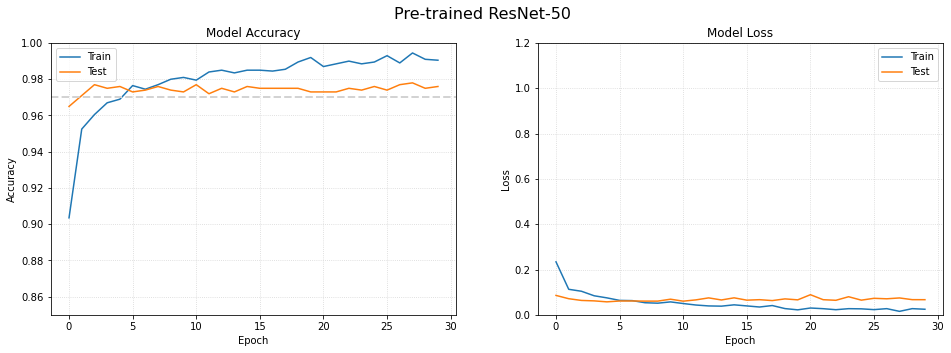

In [46]:
plot_history(history_resnet50, acc_line=0.97, title="Pre-trained ResNet-50", acc_lim=[0.85,1.0])

In [47]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
    shuffle = False,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


In [48]:
test_loss, test_acc = model.evaluate (test_generator, steps = 50)

50/50 [==============================] - 42s 846ms/step - loss: 0.1078 - accuracy: 0.9690


In [49]:
print (test_acc)

0.968999981880188
